<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 2</h1>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

### Table of Contents

- [Packages](#packages)
- [Part A](#part-a)
- [Part B](#part-b)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

***

<a id='part-a'></a>
***
<h1 align="center">Part A</h1>

### Table of Contents

- [Generate Synthetic Data](#a-synthetic-data)
- [Log-Likelihood Function](#a-log-likelihood)
- [Log-Prior Distribution](#a-log-prior)
- [Log-Posterior Distribution](#a-log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#a-amha)
- [Running the Algorithm](#a-run-algo)

<a id='a-synthetic-data'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

Since this tutorial is focused on the fact that we're fitting a normal distribution given that we have some known parameters, lets first generate the random normal distribution that we are going to fit given parameters $\mu = 10$ and $\sigma = 10$:

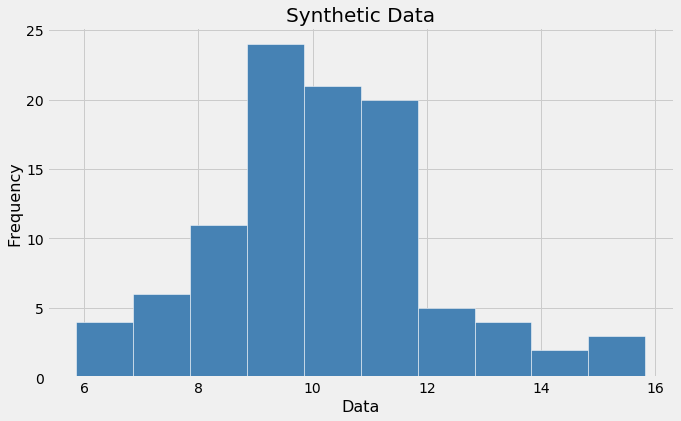

In [77]:
def generate_synthetic_data(mu, sigma, plot=False):
    data_meas = stats.norm.rvs(loc=mu, scale=sigma, size=100)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param, sigma_param = 10, 2
data_meas = generate_synthetic_data(mu_param, sigma_param, True)

***

<a id='a-log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

In [78]:
def loglikelihood(parameters, data_meas):
    mu, sigma = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.norm.logpdf(x=data_meas[i], loc=mu, scale=sigma)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='a-log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

In [66]:
def logprior(parameters):
    mu, sigma = parameters
    
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    
    if sigma <= 0 or sigma >= 1000:
        return -np.inf
    
    return mu_logpdf + np.log(1 / 1000)

***

<a id='a-log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

In [68]:
def logpost(parameters, data_meas):
    pi = logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='a-amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

The Adaptive Metropolis (AM) algorithm of Haario et al. (2001) is an extension of the Metropolis-Hastings algorithm that adapts based on the observed covariance matrix from the history of the chains. AM is historically significant as the first adaptive MCMC algorithm.

In [88]:
def runner(
    m, n_iter, data_meas=data_meas, logpost=logpost, t=1000, stepsize=[0.01, 0.01]
):
    # set up the different chains
    chains = []
    for i in range(m):
        mu_init = np.random.randint(low=6, high=12)
        sigma_init = np.random.randint(low=1, high=4)
        theta = [mu_init, sigma_init]
        state = State(theta, logpost(theta, data_meas))
        chains.append(AdaptiveMCMC(state, logpost, stepsize, data_meas, t))
    # run the algorithm on all of the chains
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        mu, sigma, l, r = adaptive_mcmc(chains[i], n_iter)
        mcmc_chains.append([mu, sigma])
        ar.append(r)
        ls.append(l)
    # return
    return mcmc_chains, ar, ls

In [83]:
eps = 0.0001
d = 2
I_d = np.identity(d)
S_d = (2.4) ** 2 / d


def update_cov(X):
    cov = np.cov(X)
    return S_d * cov + I_d * eps * S_d


class State:
    def __init__(self, state, value):
        self.state = state
        self.value = value


class AdaptiveMCMC:
    def __init__(self, initial, logposterior, stepsize, data_measa, t):
        self.current = initial
        self.logpost = logposterior
        self.stepsize = stepsize
        self.data_meas = data_meas
        self.t = t

    def random_move(self, t, X):
        if t <= self.t:
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [84]:
def adaptive_mcmc(problem, n_iter):
    u, s = [problem.current.state[0]], [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    np.seterr(over="ignore")
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1 - p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                lpost.append(lpost[-1])

    return (u, s, lpost, n_accept / S)

***

<a id='a-gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic</h2>
[Back to top](#top)

In [85]:
def GR_diag(parameter, interval=100, start=100):
    # go through each of the chains and calculate the
    # potential scale reduction factor
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(chains):
    # u_i - the average for each chain
    u = [np.mean(chain) for chain in chains]
    # s_i - the variance for each chain
    s = [np.var(chain, ddof=1) for chain in chains]
    # m - the number of sequences
    m = len(chains)
    # n - the length of each chain
    n = len(chains[0])
    # ubar - the overall average of the chains
    ubar = np.mean(u)
    # B, W - find the bewteen- and within-chain variance
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - ubar)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    # Var - the overall variance of the chains
    Var = (1-(1/n))*W + (B/n)
    # R - the potential scale reduction factor
    return np.sqrt(Var/W)

***

<a id='a-ac-function'></a>
***
<h2 align="center">Auto-Correlation Function</h2>
[Back to top](#top)

In [86]:
def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ("Please increase the value of the end parameter for this function")
    return lag, acf

***

<a id='a-run-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the Adaptive MCMC algorithm... we will generate three sequences each with 10000 iterations:

In [89]:
t=1000
mcmc_chains, ar, ls = runner(m=3, n_iter=10000, t=t, data_meas=data_meas)

***

<a id='history-plots'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

In [90]:
def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()

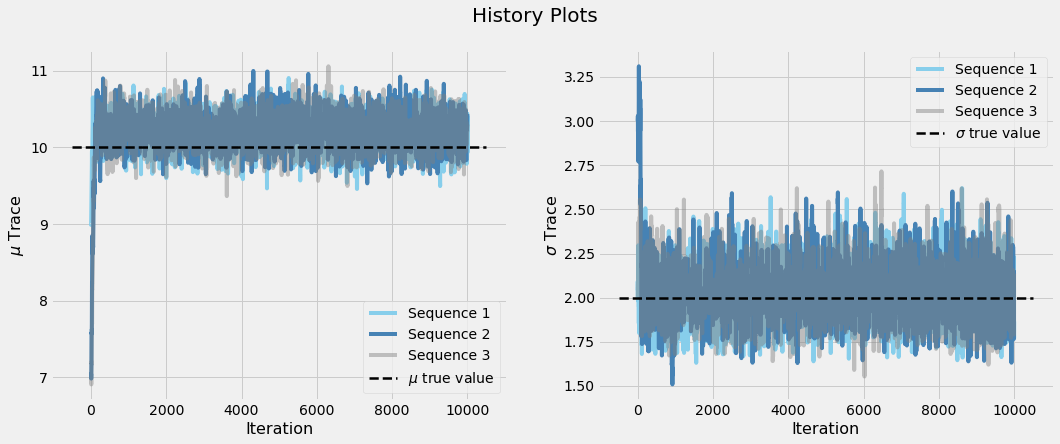

In [91]:
history_plots(mcmc_chains, [r"$\mu$", r"$\sigma$"], [10, 2])

***

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#top)

<br>

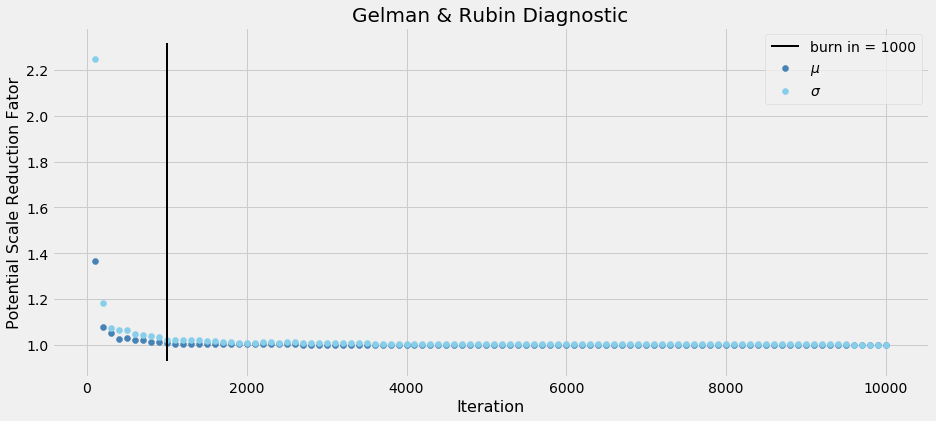

In [93]:
mu_raw, sigma_raw =[], []

for mcmc_chain in mcmc_chains:
    mu_raw.append(mcmc_chain[0])
    sigma_raw.append(mcmc_chain[1])

start, interval, end = 100, 100, len(mu_raw[0])

GR_mu, burnin_mu = GR_diag(mu_raw, interval, start)

GR_sigma, burnin_sigma = GR_diag(sigma_raw, interval, start)

burnin = max([burnin_mu, burnin_sigma, t])

plt.figure(figsize=(14, 6))
plt.scatter(x=np.arange(start, end, interval), y=GR_mu, label=r"$\mu$", color="steelblue")
plt.scatter(x=np.arange(start, end, interval), y=GR_sigma, label=r"$\sigma$", color="skyblue")
plt.plot([burnin, burnin], plt.ylim(), label="burn in = {0}".format(burnin), color="black", linewidth=2)
plt.title("Gelman & Rubin Diagnostic", fontsize=20)
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Potential Scale Reduction Fator", fontsize=16)
plt.legend(loc="best")
plt.show()

***

<a id='ac-function'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#top)

<br>

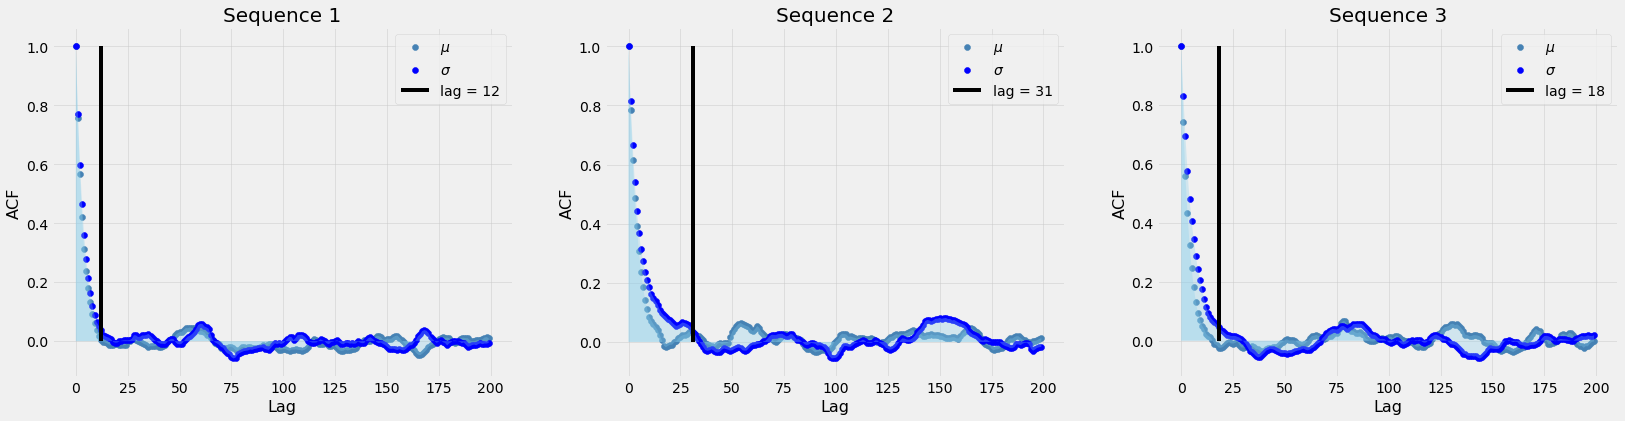

In [98]:
lag_mu = []
lag_sigma = []


acf_mu = []
acf_sigma = []

m = len(mu_raw)

end = 200
for i in range(m):
    mu_lag, mu_acf = ACF(mu_raw[i][burnin:], end)
    sigma_lag, sigma_acf = ACF(sigma_raw[i][burnin:], end)
    
    lag_mu.append(mu_lag)
    lag_sigma.append(sigma_lag)
    
    acf_mu.append(mu_acf)
    acf_sigma.append(sigma_acf)
    

lags = [max([lag_mu[i], lag_sigma[i]]) for i in range(m)]



fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
for i in range(m):
    ax[i].scatter(np.arange(0, end), acf_mu[i], label=r"$\mu$", color="steelblue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_mu[i]), y1=acf_mu[i], alpha=0.3, facecolor="skyblue")
    ax[i].scatter(np.arange(0, end), acf_sigma[i], label=r"$\sigma$", color="blue")
    ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_sigma[i]), y1=acf_sigma[i], alpha=0.3, facecolor="skyblue")
    ax[i].vlines(x=lags[i], ymin=0, ymax=1, label="lag = {0}".format(lags[i]))
    ax[i].set_title("Sequence {0}".format(i+1), fontsize=20)
    ax[i].set_xlabel("Lag", fontsize=16)
    ax[i].set_ylabel("ACF", fontsize=16)
    ax[i].legend(loc="best")
    ax[i].grid(alpha=0.5)
plt.show()

***

<a id='histograms'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#top)

<br>

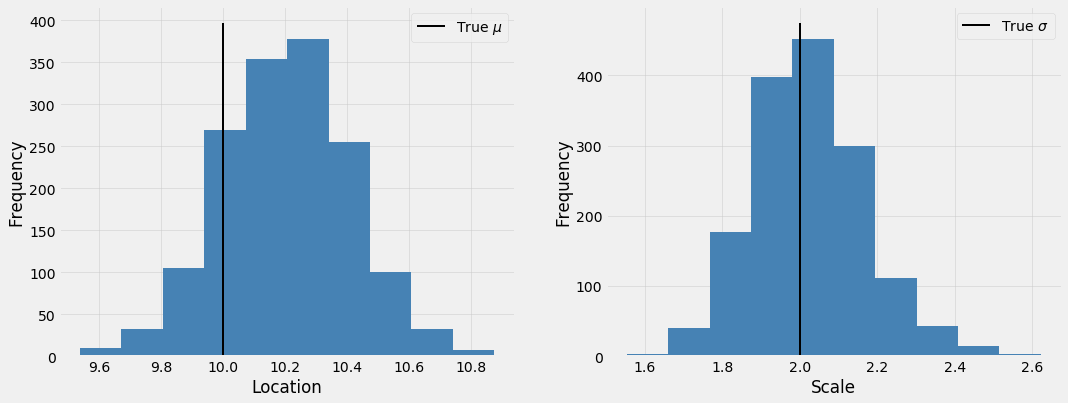

In [104]:
# merge the parameters

n_iter = len(mu_raw[0])

m = len(mu_raw)

# this is the final list for location parameter
mu_analysis = [] 

# this is the final list for scale parameter
sigma_analysis = []

# this is a list of tuples, each tupel is in this format (location, scale)
params_analysis = []


# merge all three sequences 
for i in range(m):
    for j in range(burnin, n_iter, lags[i]):
        mu_analysis.append(mu_raw[i][j])
        sigma_analysis.append(sigma_raw[i][j])
        params_analysis.append((mu_raw[i][j], sigma_raw[i][j]))


        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].hist(mu_analysis, color='steelblue')
ax[0].plot([mu_param, mu_param], ax[0].get_ylim(), label= r"True $\mu$", color="black", linewidth=2)
ax[0].set_xlabel("Location")
ax[0].set_ylabel("Frequency")
ax[0].grid(alpha=0.5)
ax[0].legend(loc='best')

ax[1].hist(sigma_analysis, color='steelblue')
ax[1].plot([sigma_param, sigma_param], ax[1].get_ylim(), label= r"True $\sigma$", color="black", linewidth=2)
ax[1].set_xlabel("Scale")
ax[1].set_ylabel("Frequency")
ax[1].grid(alpha=0.5)
ax[1].legend(loc='best')

plt.show()

***

<a id='max-ls'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#top)

<br>

In [109]:
max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
iterj = max_indices[seqi]
max_params = (mu_raw[seqi][iterj], sigma_raw[seqi][iterj])

print ("The parameter set with max log-poster score are mu = {:.2f}, sigma = {:.2f}".format(max_params[0],max_params[1]))

The parameter set with max log-poster score are mu = 10.22, sigma = 1.99


***

***

<a id='part-b'></a>
***
<h1 align="center">Part B</h1>

### Table of Contents

- [Generate Synthetic Data](#b-synthetic-data)
- [Log-Likelihood Function](#b-log-likelihood)
- [Log-Prior Distribution](#b-log-prior)
- [Log-Posterior Distribution](#b-log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#b-amha)
- [Gelman-Rubin Diagnostic](#b-gr-diagnostic)
- [Running the Algorithm](#b-run-algo)
- [Diagnostic Plots](#b-diagnostic-plots)

<a id='b-synthetic-data'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

Since this tutorial is focused on the fact that we're fitting a gev distribution given that we have some known parameters, lets first generate the random gev distribution that we are going to fit given parameters $\mu = 400$ and $\sigma = 100$ and $\xi = -0.4$, note that $\xi \Rightarrow \text{shape parameter}$:

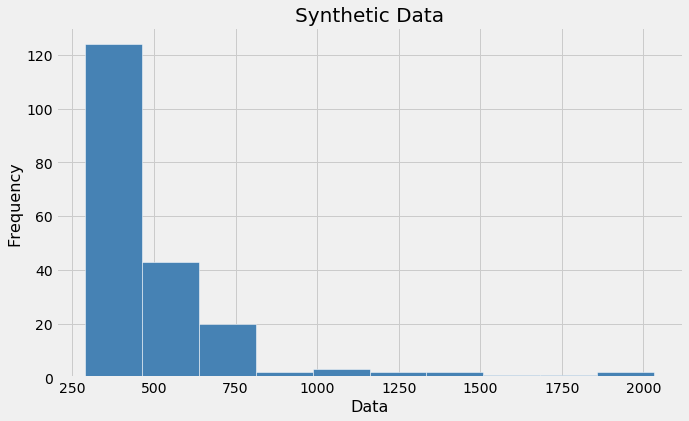

In [242]:
def generate_synthetic_data(mu, sigma, shape, plot=False):
    data_meas = stats.genextreme.rvs(loc=mu, scale=sigma, c=shape, size=200)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param, sigma_param, shape_param = 400, 100, -0.4
data_meas = generate_synthetic_data(mu_param, sigma_param, shape_param, True)

***

<a id='b-log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

The likelihood function is almost exactly the same as the previous tutorial (Part 2A), but now instead of using the Normal distribution's PDF, we are going to use the GEV distribution's PDF:

In [166]:
def loglikelihood(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='b-log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

In [176]:
def logprior(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf

***

<a id='b-log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

<br>

Same as the previous tutorials, the log-posterior is still just the sum of the log-prior and the log-posterior:

In [188]:
def logpost(parameters, data_meas):
    pi = logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='b-amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

In [211]:
def sequences_generator(m, n_iter, data_meas=data_meas, logpost=logpost, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)
    
    if likelihood([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]
        
    elif likelihood([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1
        
    elif likelihood([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1
        
    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0
        
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(AdaptiveMCMC(state, logpost, stepsize, data_meas, t))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        u, s, shape, l, r = adaptivemcmc(problems[i], n_iter)
        mcmc_chains.append([u, s, shape])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [212]:
d = 3
I_d = np.identity(d)
eps = 0.0001
S_d = (2.4)**2/d

def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class AdaptiveMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [213]:
def adaptivemcmc(problem, n_iter):

    u = [problem.current.state[0]] 
    s = [problem.current.state[1]]
    shape = [problem.current.state[2]]
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s, shape])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            shape.append(nextMove[2])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                shape.append(nextMove[2])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                shape.append(shape[-1])
                lpost.append(lpost[-1])

    return (u, s, shape, lpost, n_accept/S)

***

<a id='b-run-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the Adaptive MCMC algorithm... we will generate three sequences each with 10000 iterations:

In [214]:
t=1000
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=10000, t=t)

In [243]:
loc_est = np.median(data_meas)
scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
shape_est = 0
gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)

In [244]:
gevfit

(-0.43318486967549696, 392.53203601749863, 89.920433681942399)

***

<a id='history-plots'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

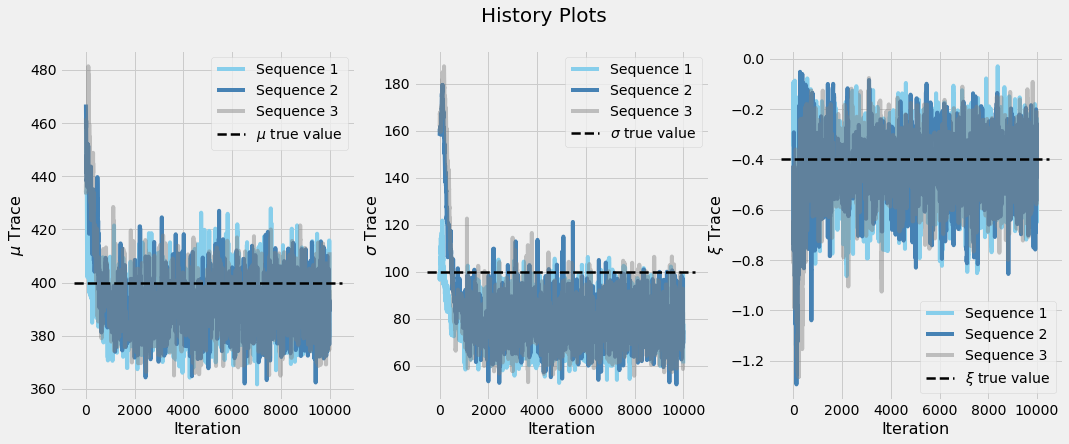

In [215]:
history_plots(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], [400, 100, -0.4])

<br>

Let us also use Thinning to find the lag for each chain:

<br>

Finally, let's merge all sequences into one final parameter sets pool:

In [ ]:
# merge the parameters

n_iter = len(u_raw[0])

m = len(u_raw)

# this is the final list for location parameter
u_analysis = [] 

# this is the final list for scale parameter
s_analysis = []

# this is the final list for shape parameter
shape_analysis = []

# this is a list of tuples, each tupel is in this format (location, scale, shape)
params_analysis = []


# merge all three sequences 
for i in range(m):
    for j in range(burnin, n_iter, lags[i]):
        u_analysis.append(u_raw[i][j])
        s_analysis.append(s_raw[i][j])
        shape_analysis.append(shape_raw[i][j])
        params_analysis.append((u_raw[i][j], s_raw[i][j], shape_raw[i][j]))


        
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax[0].hist(u_analysis, color='steelblue')
ymin1, ymax1 = ax[0].get_ylim()
ax[0].vlines(x=mu_param, ymin=ymin1, ymax=ymax1, label="Tru location")
ax[0].set_xlabel("Location")
ax[0].set_ylabel("Frequency")
ax[0].grid(alpha=0.5)
ax[0].legend(loc='best')

ax[1].hist(s_analysis, color='steelblue')
ymin2, ymax2 = ax[1].get_ylim()
ax[1].vlines(x=sigma_param, ymin=ymin2, ymax=ymax2, label="True scale")
ax[1].set_xlabel("Scale")
ax[1].set_ylabel("Frequency")
ax[1].grid(alpha=0.5)
ax[1].legend(loc='best')

ax[2].hist(shape_analysis, color='steelblue')
ymin3, ymax3 = ax[2].get_ylim()
ax[2].vlines(x=shape_param, ymin=ymin3, ymax=ymax3, label="True shape")
ax[2].set_xlabel("Shape")
ax[2].set_ylabel("Frequency")
ax[2].grid(alpha=0.5)
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

<br>

Then, we can get the max log-posterior score parameter set:

In [220]:
max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
iterj = max_indices[seqi]
max_params = (u_raw[seqi][iterj], s_raw[seqi][iterj], shape_raw[seqi][iterj])

print ('The parameter set with max log-poster score are location = {:.4f}, scale = {:.4f}, shape = {:.4f}'.format(max_params[0],max_params[1], max_params[2]))

NameError: name 'u_raw' is not defined

***

<a id='b-diagnostic-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

Now we have a pool of parameter sets which we can use to analysis. For the sea-level data, we usually have three diagnostic plots:

<br>

### 1. Return Level Plot

In [ ]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))

In [ ]:
plt.figure(figsize=(18, 12))
plt.plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
plt.scatter(np.log10([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)]), np.sort(data_meas), label='actual sorted observations', color='black', marker='X')
plt.fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
plt.fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
plt.legend(loc='upper left')
plt.xticks(np.log10([1,2,5,10,20,100,200,500]), [1,2,5,10,20,100,200,500])
plt.title('Return Level Plot', fontsize=14)
plt.xlabel('Return Period', fontsize=14)
plt.ylabel('Return Level', fontsize=14)
plt.show()

<br>

### 2. Quantile Plot

In [ ]:
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
plt.figure(figsize=(12, 8))
plt.scatter(empirical, np.sort(data_meas), color='steelblue')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
axmax = max([xmax, ymax])
plt.plot(np.arange(0, axmax), np.arange(0, axmax), label='y=x', color='black')
plt.title('Quantitle Plot', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical', fontsize=14)
plt.legend(loc='best')
plt.show()

<br>

### 3. Density Plot

In [ ]:
x_range = np.arange(0, max(data_meas)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]
plt.figure(figsize=(14,8))
plt.hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
plt.plot(x_range, y_range, label='Best Model', color='black')
plt.plot(data_meas, np.zeros_like(data_meas), 'b+', ms=20, color='black', label='observations')
plt.legend()
plt.title('Density Plot', fontsize=14)
plt.xlabel('Max Sea Level', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.show()

***